In [22]:
from IPython.display import display
import numpy as np
# import modin.pandas as pd
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

# np.random.seed(4590)
nf_data_path = r'../../Data/noFinacialFeatures.csv'
f_data_path = r'../../Data/FinacialFeatures.csv'
flevel = json.load(open(r'../FeatureEngineering/feature_level.json'))

In [2]:
nf_df = pd.read_csv(nf_data_path)
f_df = pd.read_csv(f_data_path)

In [3]:
df = pd.DataFrame()
df = nf_df.copy()

f_df.drop(['企业总评分'], axis=1, inplace=True)
df = df.merge(f_df, how='left', on='企业编号')
# first_level = flevel['first_level']
# first_level.append('企业编号')
# first_level.append('企业总评分')
# df = df[first_level]
df.head(5)

,企业编号,企业总评分,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
0,1001,75.374276,1.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0,...,107.589270,191.707773,63.791689,44.495607,0.151392,414.778035,1089.655763,176.283983,325.371499,1.562757
1,1002,79.830122,2.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,46.903333,56.590000,39.830000,6.234116,0.023916,6.506667,7.040000,5.010000,0.702335,0.045330
2,1003,78.318264,2.0,0.0,1.0,1.0,1.0,0.0,1.0,442.0,...,84.275556,139.910000,56.020000,33.143654,-0.040224,54.918889,75.540000,38.010000,11.089465,0.031792
3,1004,83.253376,0.0,6.0,1.0,0.0,0.0,2.0,1.0,1.0,...,26.720000,35.360000,17.290000,6.024438,0.081857,6.954444,7.900000,6.240000,0.618448,0.021711
4,1005,83.291493,6.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,...,94.050000,110.260000,77.850000,9.652235,0.012921,108.584444,357.190000,44.160000,101.728838,0.344086


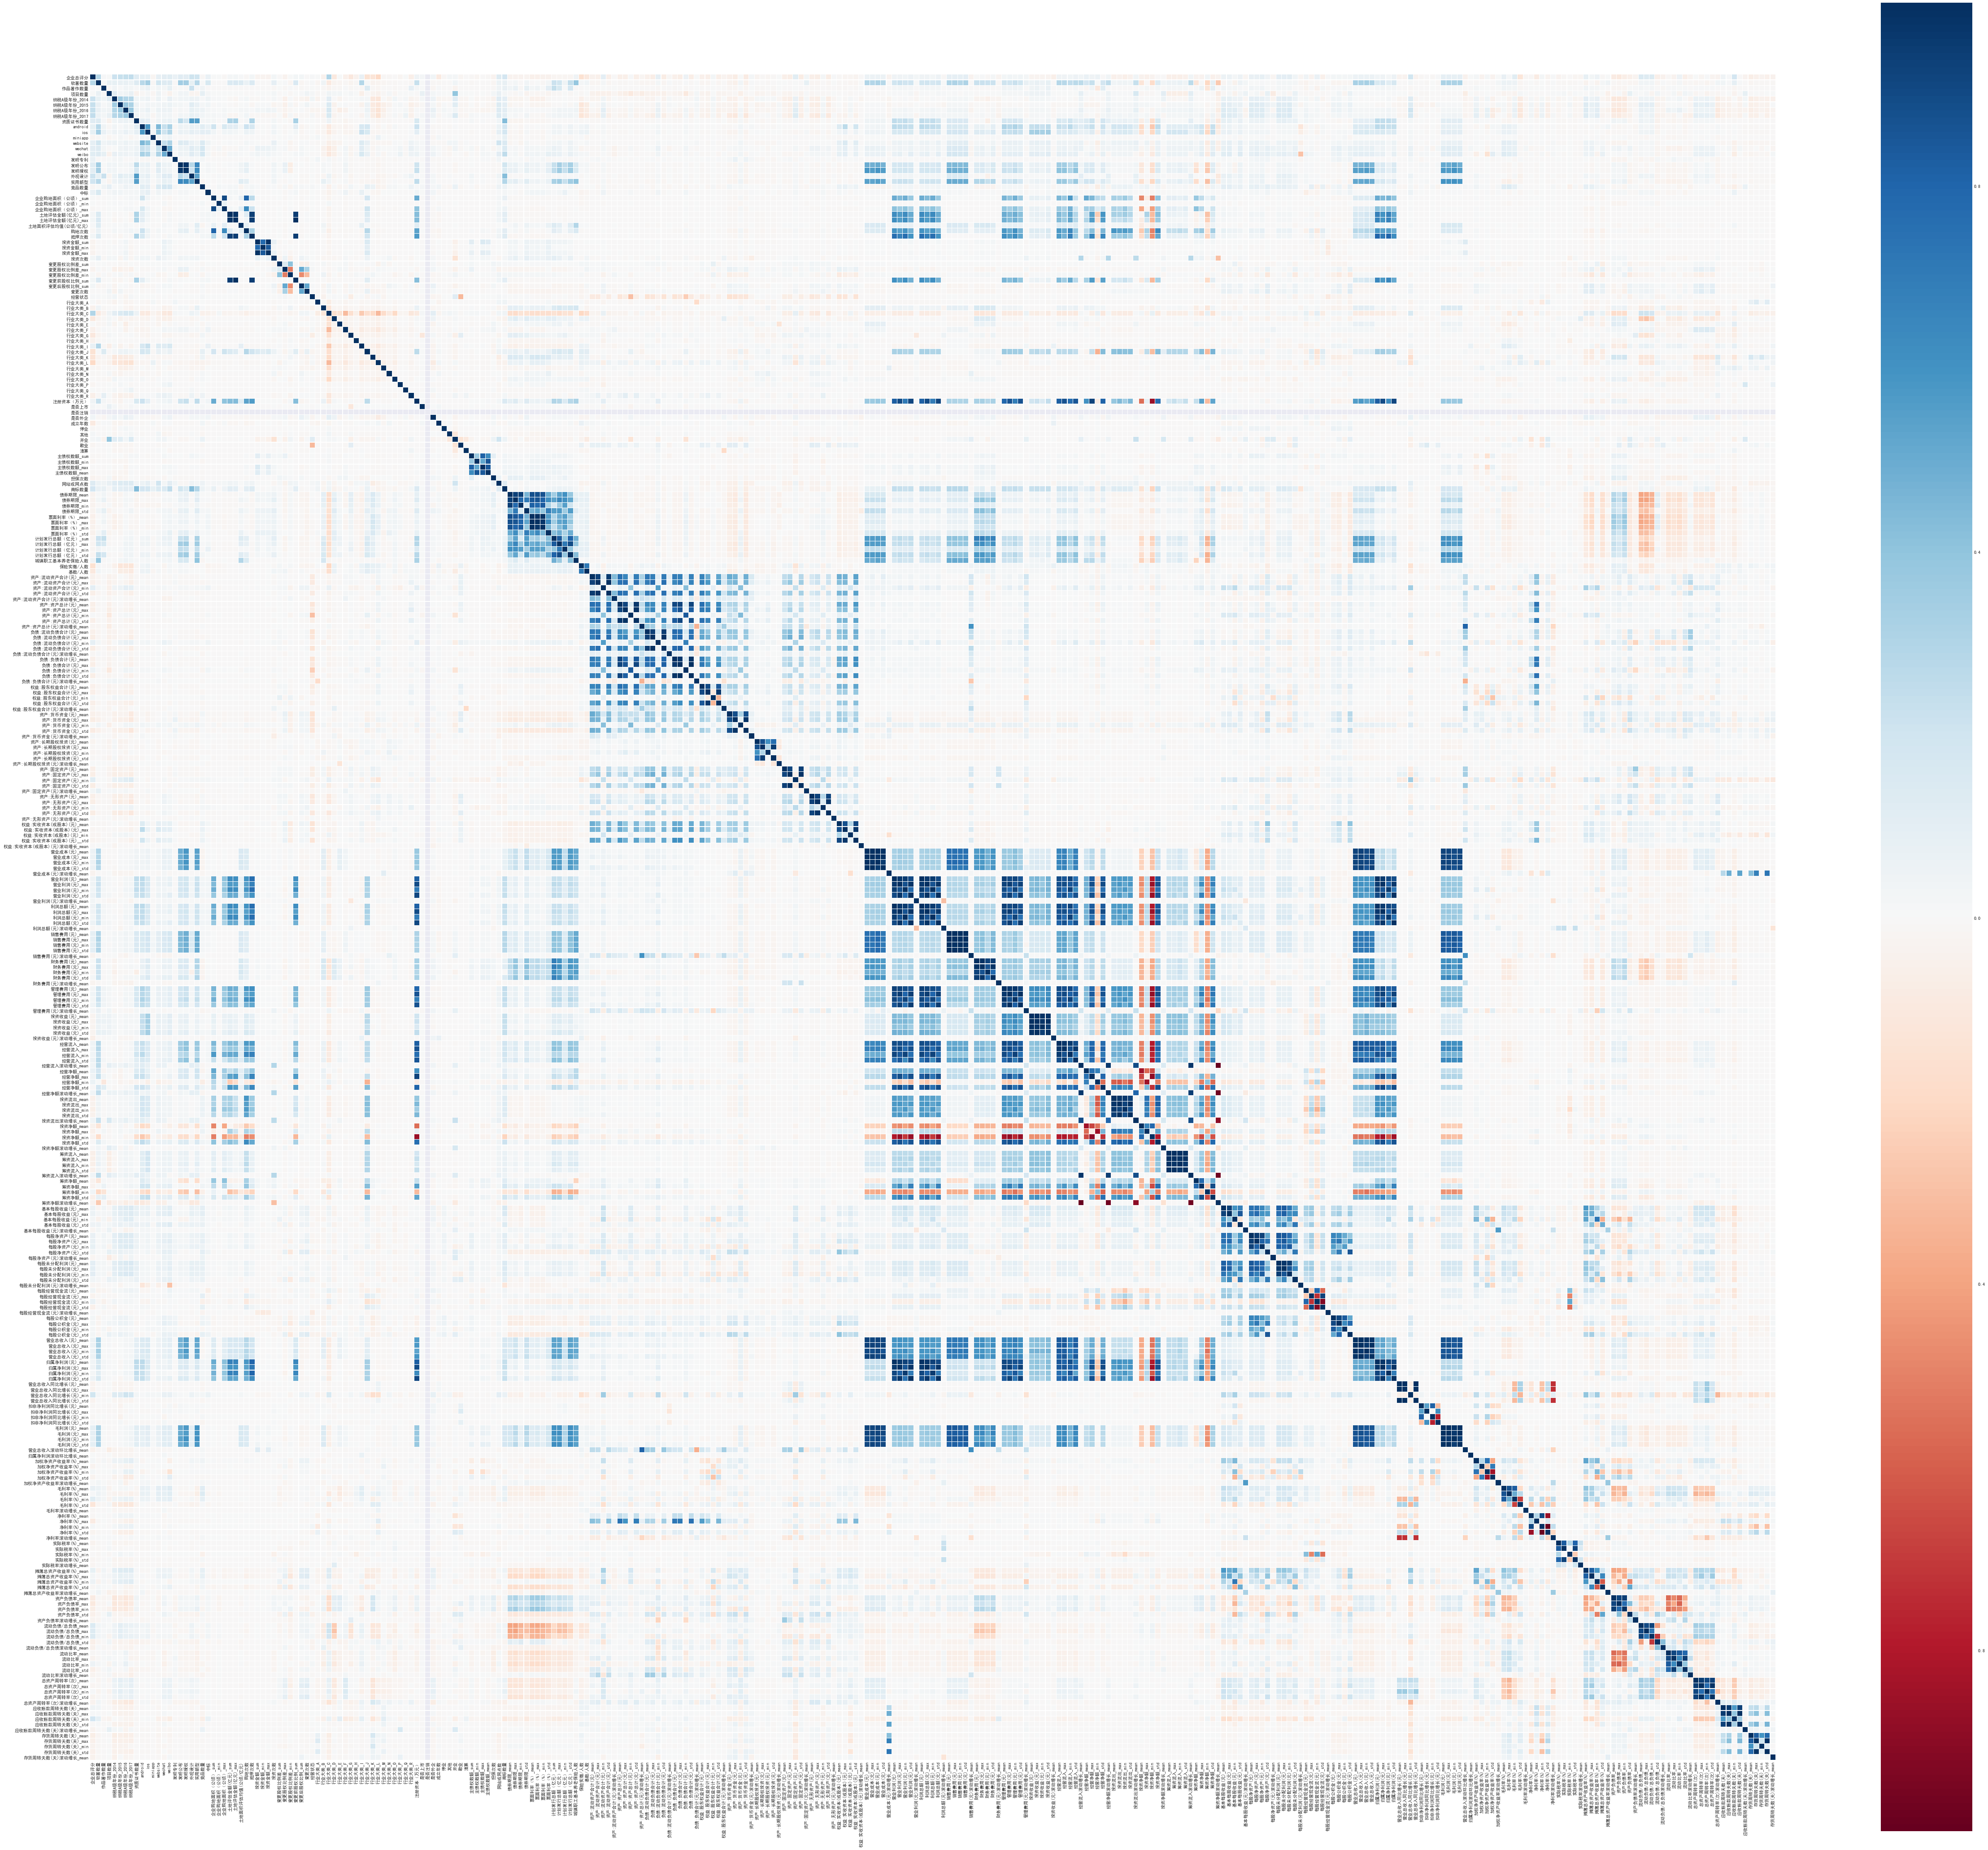

In [4]:
df_d = df.drop(['企业编号'], axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(75, 75))
sns.heatmap(df_d.corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=False)

In [5]:
y = df[['企业编号', '企业总评分']]
x = df.drop(['企业总评分'], axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=0)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((2364, 307), (592, 307), (2364,), (592,))

In [26]:
xtrain.set_index(np.arange(0, len(xtrain)), inplace=True)
# ytrain.set_index(np.arange(0, len(ytrain)), inplace=True)
xtrain.head(5)

,企业编号,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,android,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
0,2574,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,...,54.442222,81.72,37.76,19.800624,-0.035790,94.313333,175.92,30.22,58.951289,-0.067428
1,1121,0.0,0.0,2.0,2.0,0.0,0.0,0.0,8.0,0.0,...,121.655556,156.98,88.91,17.353128,0.015472,125.791667,221.92,77.28,45.120232,0.005389
2,3745,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,96.008889,118.56,42.92,25.293863,-0.027840,2.306667,3.18,1.46,0.655038,0.136693
3,2475,6.0,4.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,...,142.906111,343.31,10.25,120.287790,0.166476,437.723889,1111.39,113.25,301.697398,0.233617
4,3441,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,70.657778,84.38,65.87,5.571395,0.009875,2466.996667,2753.71,2203.02,175.901682,-0.002600


In [6]:
id_train = xtrain['企业编号']
id_test = xtest['企业编号']
xtrain.drop(['企业编号'], axis=1, inplace=True)
xtest.drop(['企业编号'], axis=1, inplace=True)

In [28]:
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# sc_X.fit_transform(xtrain)
# xtest = sc_X.transform(xtest)
# xtrain, xtest
# xtrain = (xtrain - xtrain.mean())/xtrain.std(ddof=0)
# xtest = (xtest - xtest.mean())/xtest.std(ddof=0)
# xtrain.head(5)

array([[-0.20359416, -0.0686413 , -4.23353434, ..., -0.08740562,
        -0.05647905, -0.0494079 ],
       [-0.20359416, -0.0686413 ,  4.38668546, ..., -0.05996059,
        -0.06018744, -0.04718714],
       [ 0.16102447, -0.0686413 ,  0.07657556, ..., -0.10417824,
        -0.07210945, -0.04318266],
       ...,
       [-0.20359416, -0.0686413 ,  0.07657556, ..., -0.07082546,
        -0.07132572, -0.04766587],
       [-0.13729986, -0.05865434,  0.07657556, ..., -0.0595057 ,
        -0.06837304, -0.04785668],
       [-0.20359416, -0.0686413 ,  0.07657556, ..., -0.07753801,
        -0.05792589, -0.04351812]])

# lightGBM

In [35]:
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=15)

In [36]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30,
         'objective': 'regression',
         'max_depth': 10,
         'learning_rate': 0.005,
         "min_child_samples": 100,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [38]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

    trn_data = lgb.Dataset(x0, label=y0)
    val_data = lgb.Dataset(x1, label=y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data],
                    verbose_eval=500, early_stopping_rounds=150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(xtest,
                         num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.09035	valid_1's rmse: 2.99679
Early stopping, best iteration is:
[737]	training's rmse: 1.71375	valid_1's rmse: 2.97594
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.07784	valid_1's rmse: 3.32896
Early stopping, best iteration is:
[813]	training's rmse: 1.59762	valid_1's rmse: 3.29674
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.09379	valid_1's rmse: 3.0657
Early stopping, best iteration is:
[701]	training's rmse: 1.76151	valid_1's rmse: 3.02552
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.07803	valid_1's rmse: 3.32006
[1000]	training's rmse: 1.43338	valid_1's rmse: 3.24266
Early stopping, best iteration is:
[1113]	training's rmse: 1.33562	valid_1's rmse: 3.23997
----
fold n°4
Training until validation scores don't imp

In [37]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis=1)

plt.figure(figsize=(20, 100))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                  ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

NameError: name 'feature_importance_df' is not defined

In [16]:
np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))

3.013483214003536

In [ ]:
# xsub = pd.DataFrame()
# xsub['企业编号'] = id_test
# xsub['企业总评分'] = mfull.astype(int)
# xsub.to_csv('sub_lgb_scaling.csv', index=False)

# Random Forest

In [18]:
ranks = {}
colnames = xtrain.columns


def pre_rmse(pre):
    return np.sqrt(mean_squared_error(pre.astype(int), ytest.astype(int)))


def ranking(ranks, names, order=1):
    stand = StandardScaler()
    ranks = stand.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks))

In [8]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(xtrain, ytrain)
ranks["RF"] = ranking(rf.feature_importances_, colnames)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50building tree 3 of 50

building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


# RFE

In [9]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(xtrain, ytrain)
# stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose=3)
rfe.fit(xtrain, ytrain)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
Fitting estimator with 298 features.
Fitting estimator with 297 features.
Fitting estimator with 296 features.
Fitting estimator with 295 features.
Fitting estimator with 294 features.
Fitting estimator with 293 features.
Fitting estimator with 292 features.
Fitting estimator with 291 features.
Fitting estimator with 290 features.
Fitting estimator with 289 features.
Fitting estimator with 288 features.
Fitting estimator with 287 features.
Fitting estimator with 286 features.
Fitting estimator with 285 features.
Fitting estimator with 284 features.
Fitting estimator with 283 features.
Fitting estimator with 282 features.
Fitting estimator with 281 features.
Fitting estimator with 280 features.
F

Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 fe

In [25]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(xtrain, ytrain)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge
ridge = Ridge(alpha=7)
ridge.fit(xtrain, ytrain)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(xtrain, ytrain)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

# decision tree regression
dtr = DecisionTreeRegressor()
dtr.fit(xtrain, ytrain)
ranks["DTR"] = ranking(np.abs(dtr.feature_importances_), colnames)

# adaboost regression
rng = np.random.RandomState(1)
adar = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                         n_estimators=300, random_state=rng)
adar.fit(xtrain, ytrain)
ranks["AdaR"] = ranking(np.abs(adar.feature_importances_), colnames)

In [26]:
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name]
                             for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str,
                                          [ranks[method][name] for method in methods]))))

	AdaR	DTR	Lasso	LinReg	Ridge	Mean
软著数量	9.01	3.8	0.05	-0.33	-0.43	2.42
作品著作数量	1.02	-0.16	-0.17	-0.34	-0.51	-0.03
项目数量	-0.48	-0.16	-0.17	-0.13	1.1	0.03
纳税A级年份_2014	-0.28	-0.16	4.26	-0.05	1.69	1.09
纳税A级年份_2015	0.39	-0.11	2.04	-0.15	0.79	0.59
纳税A级年份_2016	3.33	0.51	2.98	-0.2	0.65	1.45
纳税A级年份_2017	1.69	-0.16	5.6	0.03	2.31	1.89
资质证书数量	5.43	3.37	-0.13	-0.34	-0.5	1.57
android	-0.48	-0.16	-0.16	-0.33	-0.46	-0.32
ios	-0.45	-0.16	0.12	-0.32	-0.38	-0.24
miniapp	-0.48	-0.16	-0.17	-0.21	0.3	-0.14
website	-0.33	-0.08	-0.08	-0.33	-0.47	-0.26
wechat	-0.24	-0.16	4.07	-0.04	1.74	1.07
weibo	-0.48	-0.15	0.09	-0.28	-0.02	-0.17
发明专利	-0.48	-0.16	1.68	-0.19	0.72	0.31
发明公布	5.32	16.45	-0.17	-0.34	-0.51	4.15
发明授权	5.81	0.33	-0.17	-0.34	-0.51	1.02
外观设计	2.89	1.1	-0.16	-0.34	-0.51	0.6
实用新型	2.3	0.86	-0.15	-0.34	-0.51	0.43
竞品数量	-0.24	-0.14	-0.11	-0.34	-0.48	-0.26
中标	0.94	-0.16	-0.17	-0.34	-0.51	-0.05
企业购地面积（公顷）_sum	-0.37	-0.03	-0.17	-0.34	-0.51	-0.28
企业购地面积（公顷）_min	-0.36	-0.06	-0.17	-0.34	-0.51	-0.29
企业购地面积（公顷）_max	-0.4

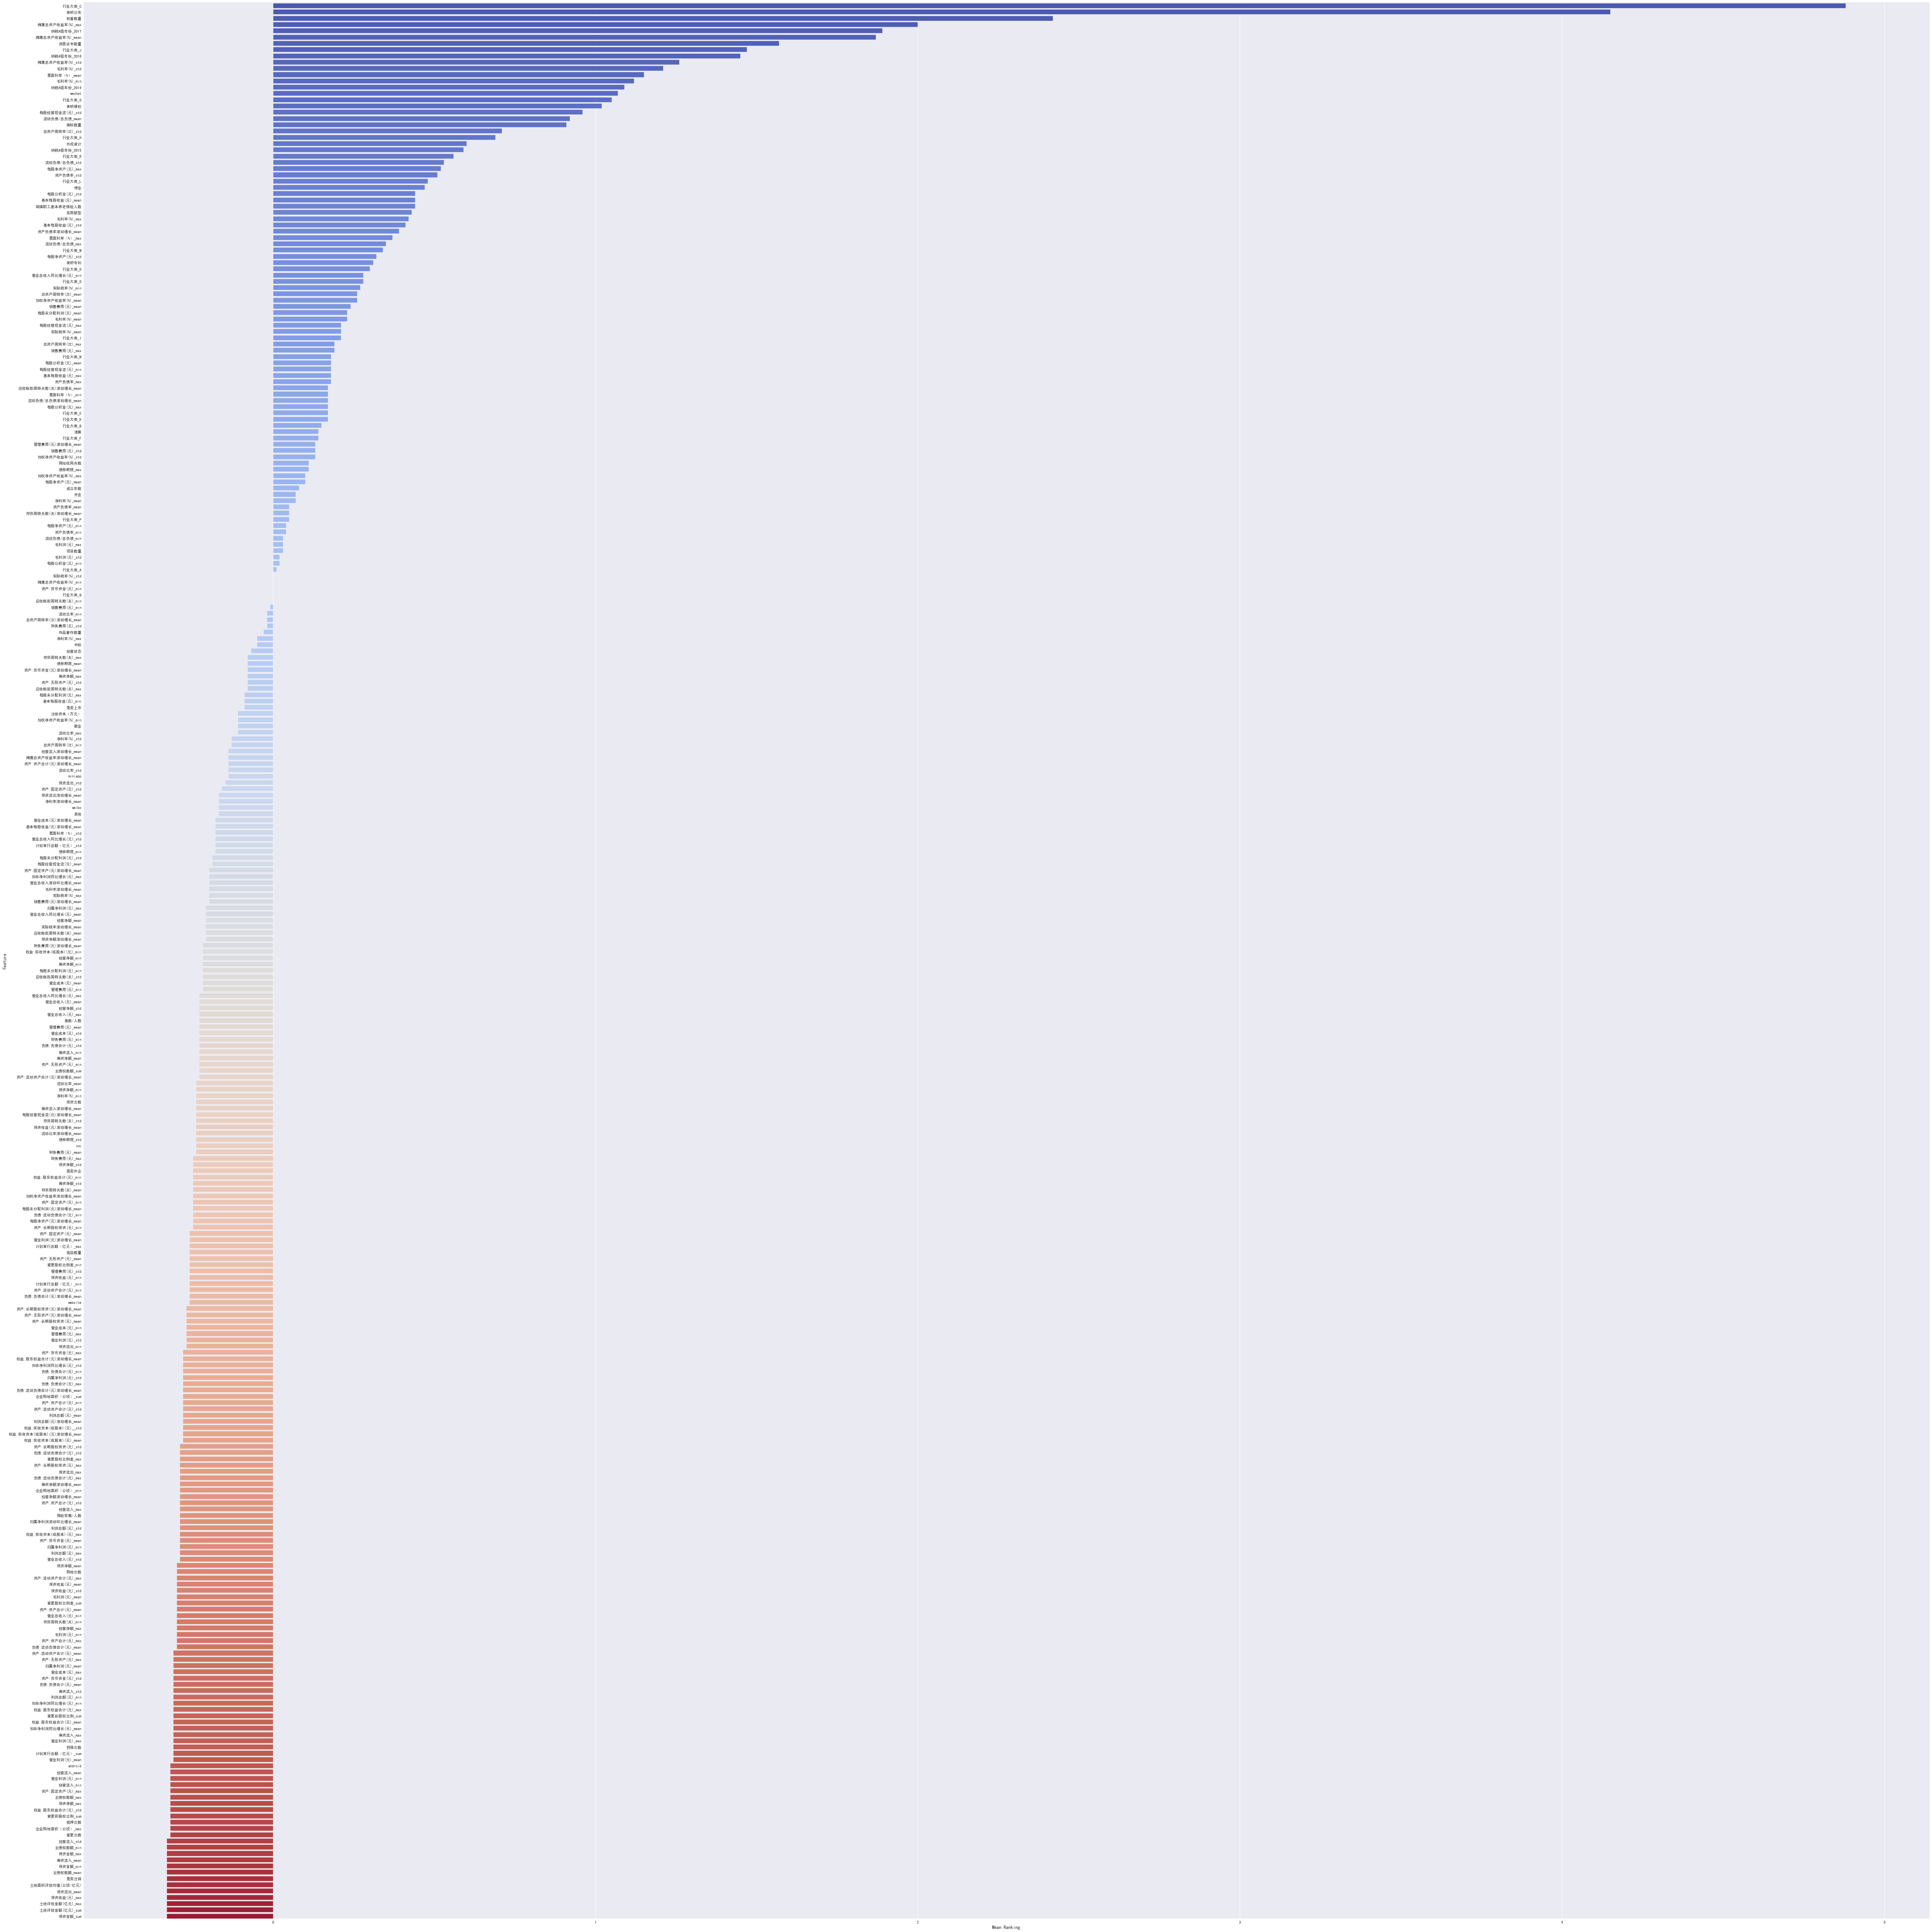

In [27]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns=['Feature', 'Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
sns.factorplot(x="Mean Ranking", y="Feature", data=meanplot, kind="bar",
               size=70, aspect=1, palette='coolwarm')

In [29]:
# random forest predict
rf_ypre = rf.predict(xtest)
pre_rmse(rf_ypre)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


3.1505040351784466

In [30]:
# linear regression predict
lr_ypre = lr.predict(xtest)
pre_rmse(lr_ypre)

10.510290967248062

In [31]:
# ridge predict
ridge_ypre = ridge.predict(xtest)
pre_rmse(ridge_ypre)

10.628874492295644

In [32]:
# lasso predict
lasso_ypre = lasso.predict(xtest)
pre_rmse(lasso_ypre)

10.01468516324497

In [33]:
# decision tree regression
dtr_ypre = dtr.predict(xtest)
pre_rmse(dtr_ypre)

4.680140619278038

In [34]:
# adaboost regression
adar_ypre = adar.predict(xtest)
pre_rmse(adar_ypre)

3.358882938507175